# Spotify Classification: predict the top genre that a song belongs to.  

This dataset includes these features:  
**Id**: unique track identifier.  
**title**: track title.  
**artist**: singer or band.  
**year**:  year of release (or re-release).  
**bpm**:  beats per minute.  
**nrgy**:  energy: higher, more energetic.  
**dnce**: danceability: higher, the easier to dance to.  
**dB**:  loudness (dB): the higher the value, the louder the song.  
**live**: liveness: higher, more likely it's a live recording.  
**val**: valence: higher, more positive mood.  
**dur**: duration: song length.  
**acous**: acousticness: higher, more acoustic.  
**spch**: speechiness: higher, more spoken word.  
**pop**:  popularity: higher is more popular.  
**top genre**:  genre of the track (class label).  


In [182]:
import pandas as pd
import numpy as np


# plotting
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [183]:
# default is 120 seconds
%autosave 60  

Autosaving every 60 seconds


## Load the data
Load the train and test data:
the train data will be split into train and validation sets
for hyperparameter tuning and to select the best model. 
The best model will be trained on the entire training set
and used to make predictions using the test set.

In [184]:
#!ls

In [185]:
dataset=pd.read_csv("ClassificationTrain.csv")
test_dataset=pd.read_csv("ClassificationTest.csv")

In [186]:
train_dataset = dataset.copy()
test_df = test_dataset.copy()

#set to True for data visualization and verbose text output 
verbose=True  

## EDA and Visualization

### Data summary
For this task our first step was to perform exporatory data analysis (EDA) and visualization.
**train_dataset.describe()** shows a summary of the numerical training data.  The range of values for each feature appears to be valid. For example, the range for bpm is 62 to 199 with a mean and median close to 120bpm, which is considered to be optimal for song popularity.  **train_dataset.info()** shows that the target class top genre is 15 missing values (453-438). Non-Null counts should be equal, rows with missing top genre values were replace by predictions made by a Logistic Regression (LR) shown in a section below. LR was more accurate than using the mode or with an instance based model such as K Nearest Neighbors (KNN). Next **value_counts() and plt.bar()** revealed that there are 86 genres, only 1 or 2 examples for most genres, and that the dataset is very unbalanced which made learning from this dataset a challenge.  

### Correlation
Multicollinearity: independent variables are strongly correlated. This can reduce model performance. The variation inflation factor (VIF) for each variable can be computed. If predictive features yield VIF values less than 5, then this would indicate that multicollinearity is not a problem. However, the ***VIF*** output below shows that bpm and dnce are over 20!

The correlation matrix below shows that dB and nrgy have the highest positively correlated features, val and dnce are second, while dnce and acoustics are the most negatively correlated. However, most of the features in this dataset have low correlation and, in fact, the application of PCA not improve classification accuracy.

### Outliers
Next we used ***sns.boxplot()*** to reveal potential outliers. The default value for the whiskers is 1.5 standard deviations. The boxplots show that some features include data point far beyond the whiskers. While it's difficult to distinguish between significant data points and outliers (noise), we found that most values greater the 3 standards from the mean were noise. 

### Clusters
t-SNE can project higher dimensional data onto a 2D space such that points that are relatively close in high dimensional space are close in 2D space.  The t-SNE plot below indicates that the songs cluster in a nonrandom way and that there pattern that may be exploited for classification.

### What worked and what did not
Most of the things we tried made either small incremetal improvement or none.  Dropping attributes (columns) usually reduced accuracy. PCA made little difference. Multiplying feature attributes,RandomOverSampling or applying other mathmematical operations on features was not useful. But one-hot encoding title, artist, and year had a big positive impact on classification accuracy. 


## Data exploration

In [187]:
# summary of numerical features
train_dataset.describe()

,Id,year,bpm,nrgy,dnce,dB,live,val,dur,acous,spch,pop
count,453.000000,453.000000,453.000000,453.000000,453.000000,453.000000,453.000000,453.000000,453.000000,453.000000,453.000000,453.000000
mean,227.000000,1991.443709,118.399558,60.070640,59.565121,-8.836645,17.757174,59.465784,226.278146,32.982340,5.660044,60.743929
std,130.914094,16.776103,25.238713,22.205284,15.484458,3.577187,13.830300,24.539868,63.770380,29.530015,5.550581,13.470083
min,1.000000,1948.000000,62.000000,7.000000,18.000000,-24.000000,2.000000,6.000000,98.000000,0.000000,2.000000,26.000000
25%,114.000000,1976.000000,100.000000,43.000000,49.000000,-11.000000,9.000000,42.000000,181.000000,7.000000,3.000000,53.000000
50%,227.000000,1994.000000,119.000000,63.000000,61.000000,-8.000000,13.000000,61.000000,223.000000,24.000000,4.000000,63.000000
75%,340.000000,2007.000000,133.000000,78.000000,70.000000,-6.000000,23.000000,80.000000,262.000000,58.000000,6.000000,71.000000
max,453.000000,2019.000000,199.000000,100.000000,96.000000,-1.000000,93.000000,99.000000,511.000000,100.000000,47.000000,84.000000


In [188]:
# feature names and their counts, Non-Null counts should be equal.
# top genre is the target (class) and has missing values (453-438)
train_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 453 entries, 0 to 452
Data columns (total 15 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Id         453 non-null    int64 
 1   title      453 non-null    object
 2   artist     453 non-null    object
 3   year       453 non-null    int64 
 4   bpm        453 non-null    int64 
 5   nrgy       453 non-null    int64 
 6   dnce       453 non-null    int64 
 7   dB         453 non-null    int64 
 8   live       453 non-null    int64 
 9   val        453 non-null    int64 
 10  dur        453 non-null    int64 
 11  acous      453 non-null    int64 
 12  spch       453 non-null    int64 
 13  pop        453 non-null    int64 
 14  top genre  438 non-null    object
dtypes: int64(12), object(3)
memory usage: 53.2+ KB


### Distribution of song genres
There are too many classes (86) and not enough examples. Most classes have only 1 or 2 examples, while three classes have over 60 examples each. 

In [189]:
y_all = train_dataset["top genre"]
value_counts=y_all.value_counts()
print("number of class names:", len(value_counts)) 

number of class names: 86


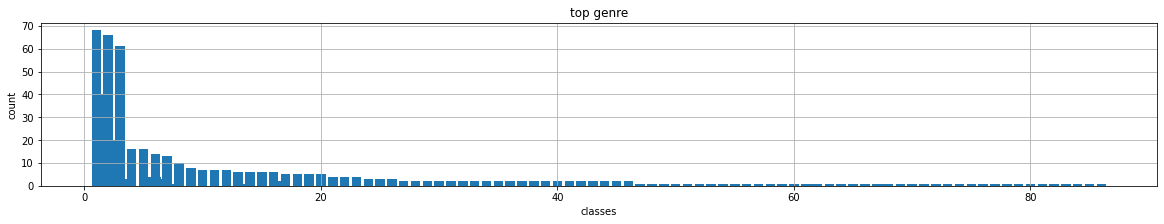

In [190]:
if verbose:
    x=[x for x in range(1,87)]
    # full training set is very unbalanced, 
    # most genres have only 1 or 2 examples
    plt.figure(figsize=(20,3)) 
    value_counts.hist(bins=86); 
    plt.bar(x, value_counts.values);
    #plt.xticks(rotation=90);
    plt.xlabel('classes')
    plt.ylabel('count');
    plt.title('top genre')

In [191]:
value_counts

adult standards       68
album rock            66
dance pop             61
brill building pop    16
glam rock             16
                      ..
bow pop                1
australian rock        1
boogaloo               1
british comedy         1
alternative rock       1
Name: top genre, Length: 86, dtype: int64

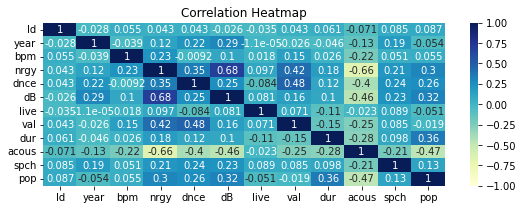

In [192]:
if verbose:
  # Plot linear correlation matrix
  cm=train_dataset.iloc[:,0:14].corr()   # make sure indices are right!
  #cm[cm<0.45]=0

  fig, ax = plt.subplots(figsize=(9,3))
  sns.heatmap(cm, annot=True, cmap='YlGnBu', vmin=-1,
  vmax=1, center=0, ax=ax)
  plt.title('Correlation Heatmap')
  plt.show()

### VIF

We calculated the variance inflation factor for each feature. The VIF is given by: **VIF = 1/(1-R^2)** where R^2 is the coefficient of determination. In general, if a feature that has a VIF value greater than 5 is considered to be highly collinear with other features in the data.  The output below shows that bpm and dnce are over 20!  We found that dropping dnce or bpm reduced classification accuracy. This was surprising and could be future work.

In [193]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

num_data=train_dataset.iloc[:,4:14].copy()   # if this fails, the indices are wrong
VIF             = pd.DataFrame()
VIF['feature']  = num_data.columns
VIF['VIF']      = [variance_inflation_factor(num_data.values, i) for i in range(num_data.shape[1])]
VIF

,feature,VIF
0,bpm,21.156908
1,nrgy,20.452345
2,dnce,22.889639
3,dB,10.736269
4,live,2.719730
5,val,11.916605
6,dur,16.750908
7,acous,3.141917
8,spch,2.282124
9,pop,24.842028


### Boxplots show outliers
The more obvious outliers (> 3 std deviations) will be  removed in some cells below.

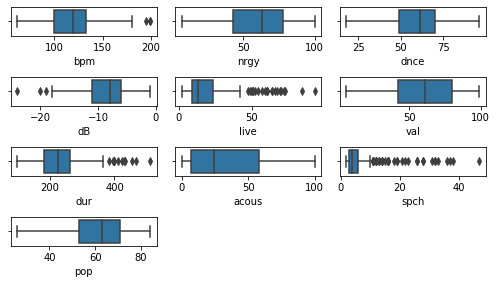

In [194]:
# boxplots: visualize data distributions and outliers
if verbose:
  plt.figure(figsize=(7,5));
  df=train_dataset.drop("top genre", axis=1, inplace=False)
  attributes=df.columns.values.tolist()
  idx=4
  for attribute in attributes[idx:]:
    plt.subplot(5,3,idx)
    sns.boxplot(x=train_dataset[attribute])
    idx=idx+1
  plt.tight_layout(pad=1)

### t-SNE shows some clustering in the training data
The cluster are not sherical, but there appears to be structure in this data.

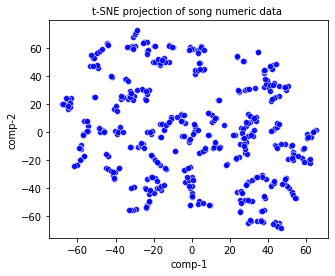

In [195]:
# cluster data point using t-SNE

show_legend=False

# visualize training data
temp_data=dataset.copy()
df = pd.DataFrame()
df["y"] = temp_data['top genre'].copy();
#temp_data.dropna(axis=0, inplace=True)
temp_data.drop(['Id','title','artist', 'top genre'], axis=1, inplace=True)

y_genre=df["y"].sort_values(ascending=False)
y_num = [ ii for ii in range(1, len(y_genre)+1)]

#temp_data.drop(['pop'], axis=1, inplace=True)

if verbose:
  import numpy as np
  from sklearn.manifold import TSNE

  X_train_embedded = TSNE(n_components=2, learning_rate='auto',
                    init='random', perplexity=3).fit_transform(temp_data)
  X_train_embedded.shape
                
  df["comp-1"] = X_train_embedded[:,0]
  df["comp-2"] = X_train_embedded[:,1]
  n_colors=len(df["y"].unique())          # must be after drop NA
  plt.figure(figsize=(5,4));
  T=sns.scatterplot(x="comp-1", y="comp-2", color='b', legend=show_legend,\
                    palette=sns.color_palette("rocket", n_colors), \
                    data=df, alpha=.9);
  plt.title('t-SNE projection of song numeric data ', fontsize=10)
    
  if show_legend:
    plt.legend(bbox_to_anchor=(1.4, 1), loc='upper right', borderaxespad=0);

# Data Pre-processing Steps on Train Set

In this section, we applied data cleaning, feature selection, and feature engineering methods.

***Cleaning***: Rows with missing values and outliers (z score > three std) were dropped.
One duplicate row was dropped.  
***Feature selection***: The "Id" column was dropped (it's not a feature). The "pop" (popularity) feature column was dropped ... "pop" was not predictive of top genre.  
***Feature engineering***: The text features "title", "artist", and "top genre" were one-hot encoded.

### One-hot encoding

Next we  one-hot encode the title, year, and artist name categorical features on the theory that they contain information revelavnt to a song's genre. Intuitively, we suspected that artist would be strongly associated with genre and predictive. However, song title was not expected to help. Nonetheless, would found that one-hot encoding all three improved classifcation accuaracy on validation data.

In [196]:
#drop the popularity of the song since it has no direct contribution in predicting top genre
dataset = dataset.drop(["Id","pop"], axis=1)
#dropping the pop column for test set
test_dataset = test_dataset.drop(["Id","pop"], axis=1)

In [197]:
#copy of the original dataset
train_dataset = dataset.copy()

In [198]:
#create top genre in the test dataset
c = "top genre"
test_dataset = test_dataset.assign(**{c: pd.Series(dtype='object')})

In [199]:
#concating the train and test dataset
concatenated_dataset = pd.concat([dataset, test_dataset])

In [200]:
#give the same column name as the original dataset 
concatenated_dataset = concatenated_dataset.reset_index(drop=True)
concatenated_dataset.columns= train_dataset.columns

In [201]:
#concatenated_dataset

In [202]:
#dividing the dataset into dependable and independent variables
x_con_data=concatenated_dataset.iloc[:,:-1]
y_con_data=concatenated_dataset.iloc[:,-1]

In [203]:
#one hot encoding

# select the categorical variables
categorical_variables = ['title','artist','year']

# perform one hot encoding
x_con_data = pd.get_dummies(x_con_data, columns=categorical_variables)

In [204]:
#adding the top genre in the one hot encoded dataset
x_con_data['top genre'] = y_con_data
#assigning the data to the variable concatenated data
concatenated_dataset = x_con_data

In [205]:
#concatenated_dataset

In [206]:
# Manually specify the row index to split the dataset
split_index = train_dataset.shape[0]

# Split the dataset into two parts
dataset = concatenated_dataset.iloc[:split_index]
test_dataset = concatenated_dataset.iloc[split_index:]

# Print the size of the training and testing datasets
print(f"Training dataset size: {np.shape(dataset)}")
print(f"Testing dataset size: {np.shape(test_dataset)}")

Training dataset size: (453, 1045)
Testing dataset size: (113, 1045)


In [207]:
#dataset

In [208]:
#test_dataset

In [209]:
# #copy of the original dataset
train_dataset = dataset.copy()

In [210]:
#checking for null values in each columns in the dataset
print(dataset.iloc[:,:-1].isnull().any())
print(dataset.iloc[:,-1].isnull().any())

bpm          False
nrgy         False
dnce         False
dB           False
live         False
             ...  
year_2015    False
year_2016    False
year_2017    False
year_2018    False
year_2019    False
Length: 1044, dtype: bool
True


In [211]:
from sklearn.model_selection import train_test_split
# Create a boolean mask of rows with missing values
mask = dataset.isnull().any(axis=1)

# Split the data into two sets: with and without missing values
test_set = dataset[mask]
train_set = dataset[~mask]

In [212]:
# Split the set without missing values into training and test sets
x_train = train_set.drop("top genre",axis=1)
y_train = train_set["top genre"]
x_test = test_set.drop("top genre",axis=1)
y_test = test_set["top genre"]

In [213]:
#checking for null values in x_train and y_train

print(x_train.isnull().any())
print(y_train.isnull().any())

bpm          False
nrgy         False
dnce         False
dB           False
live         False
             ...  
year_2015    False
year_2016    False
year_2017    False
year_2018    False
year_2019    False
Length: 1044, dtype: bool
False


In [214]:
#checking for null values in x_test and y_test
if verbose:
    print(x_test.isnull().any())
    print(y_test.isnull().any())

bpm          False
nrgy         False
dnce         False
dB           False
live         False
             ...  
year_2015    False
year_2016    False
year_2017    False
year_2018    False
year_2019    False
Length: 1044, dtype: bool
True


In [215]:
#x_train

In [216]:
#x_test

### Replace missing top genre values with predicted genres
We used Logistic Regression to replace missing top genre values instead of KNN or dropping those rows. This was the most accurate method and it preserved the useful information contained in those rows.

In [217]:
#feature scaling of the training data
from sklearn.preprocessing import StandardScaler

x_train=x_train.values
x_test=x_test.values
# Scale the input data
scaler = StandardScaler()
x_train[:,:9] = scaler.fit_transform(x_train[:,:9])
x_test[:,:9] = scaler.transform(x_test[:,:9])

In [218]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

# Define the hyperparameters and search space
params = {"C": [100], "penalty": ["l1"], "solver": ["liblinear"],"max_iter": [1000]}

# Create the logistic regression model
lr = LogisticRegression()

# Perform a grid search with 5-fold cross-validation
grid_search = GridSearchCV(estimator=lr, param_grid=params, cv=5)
grid_search.fit(x_train, y_train)

# Make predictions on the testing dataset
y_test = grid_search.predict(x_test)

In [219]:
#printing the predicted values of y_test
y_test

array(['adult standards', 'adult standards', 'adult standards',
       'dance pop', 'adult standards', 'adult standards',
       'adult standards', 'adult standards', 'adult standards',
       'album rock', 'adult standards', 'adult standards', 'dance pop',
       'album rock', 'album rock'], dtype=object)

In [220]:
# Concatenate x_train and x_test along axis 0
x = np.concatenate((x_train, x_test), axis=0)
# Concatenate y_train and y_test along axis 0
y = np.concatenate((y_train, y_test), axis=0)

In [221]:
# Convert x_train and y_train to data frames
x = pd.DataFrame(x)
y = pd.DataFrame(y)

# Merge x_train and y_train along axis 1 (i.e., horizontally)
dataset = pd.concat([x ,y], axis=1)
dataset = dataset.reset_index(drop=True)
dataset.columns= train_dataset.columns

In [222]:
#dataset

### Detect duplicate rows and delete

In [223]:
# Check for duplicates
duplicates = dataset.duplicated().sum()
print(f"Number of duplicates: {duplicates}")
dataset = dataset.drop_duplicates()

Number of duplicates: 1


### Delete rows that contain one or more outliers.

In [224]:
# Define function to handle outliers using z-score method
def handle_outliers_z_score(df, threshold=3):
    z_scores = np.abs((df - df.mean()) / df.std())
    df_out = df[(z_scores < threshold).all(axis=1)]
    return df_out

# Apply function to relevant columns
outliers_dataset = dataset.copy()
columns = ['bpm', 'nrgy', 'dnce', 'dB', 'live', 'val', 'dur', 'acous', 'spch']
df_outliers_removed = handle_outliers_z_score(outliers_dataset[columns])
dataset = pd.concat([df_outliers_removed, dataset.drop(columns, axis=1) ], axis=1)
dataset = dataset.dropna()

# Print number of rows before and after handling outliers
print(f"Original number of rows: {len(outliers_dataset)}")
print(f"Number of rows after handling outliers: {len(dataset)}")

Original number of rows: 452
Number of rows after handling outliers: 409


### Partition the training set into training examples and their class labels.

In [225]:
#dividing the dataset into dependable and independent variables
X_train=dataset.iloc[:,:-1].values
Y_train=dataset.iloc[:,-1].values

# Train Classifier Models

In this section we trained the Logistic Regression (LR), Support Vector Classifier (SVC), K Nearest Neighbors (KNN), and RandomForestClassifier (RFC) models on the training data. LR is a relatively simple and easy to use model that we expected to use it as a benchmark. The SVC is more suitable for complex data and we expected it to deliver better accuracy than LR.  KNN was selected because the t-SNE plot indicated that the songs cluster in a nonrandom way. Essentially, t-SNE projects higher dimensional data onto a 2D space such that points that are relatively close in high dimensional space are close in 2D space.

We used GridSearchCV to find the best hyperparameters and perform cross validation to identify the best model.   
See plots below.  

One interesting result was that LR delivered 100% accuracy on the training set.  Logistic regression is considered a generalized linear model because its output depends on the sum of inputs and parameters, and not on the product or quotient, etc., of those parameters. So the training partitions processed by GridSearchCV were linearly separable. Possibly thanks to one-hot encoding. Best Kaggle score was **0.59649** with hyperparameter C=91 (C=1 is the default).  So LR worked best with weak regularization.  Training accuracy ramped up very quickly, but validation accuracy improved very slowly.

Note: C is a postive float and the inverse of regularization strength. It's similar to the C hyperparameter used by support vector machines.  Smaller values result in stronger regularization.

SVC validation set accuracy increased steadily with increasing C, optimal C was ~1.6, but accuracy of ~0.37 was a distant second to LR.

The KNN plot is interesting because as K increases accuracy decrease. Of course the nearest neighbor to an instance is itself and as K increases more distant neighbors and disimilar neighbors are included in the vote. Optimal K was 8 which got an accuracy of ~0.34. This confirmed the t-SNE result during EDA that suggested there are some clusters in this dataset.

Validation accuracy of the models was mostly in the 30% to 50% range.

After selecting the best model based on accuracy on validation data before running the model on the unseen test data for submission to Kaggle. While no Kaggle test data was used for training there was a risk that some test data information "leaked" into the training data because each Kaggle score could be used as feedback and influence model training decisions.

### Summary of final results
Ultimately the Logistic Regression model got our best score on Kaggle: ***0.59649***.  random_state not set at the time, so it's only almost reproducible.  Stra-hat Pirates are 11th on the Kaggle leaderboard.
#### LR_model = LogisticRegression(C=91, max_iter=1000, penalty='l1', solver='liblinear', random_state);
#### SVC_model = SVC(C=1.6,  gamma='scale', kernel='sigmoid',  random_state=42);
#### RFC_model = RandomForestClassifier(n_estimators=400, max_depth=14, random_state=42)
#### KNN_model = KNeighborsClassifier(n_neighbors=8,  weights='uniform', random_state=42);


Typical and reprodicible results are shown in this table and the plots below.

| Model | Train Acc | Validation Acc |
| --- | --- | --- |
| Logistic Regression | 1.0 | 0.528 |
| SVC             | 0.519 | 0.371 |
| Random Forest   | 0.619   |  0.396  |
| KNN            |  0.625   | 0.344   |

## Logistic Regression

In [226]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

C=np.arange(1,110,10)

# Define the hyperparameters and search space
params = {"C": C, "penalty": ["l1"], "solver": ["liblinear"],"max_iter": [1000]}

# Create the logistic regression model
lr = LogisticRegression(random_state=42)

# Perform a grid search with 5-fold cross-validation
grid_search = GridSearchCV(estimator=lr, param_grid=params, cv=5,\
                           return_train_score=True)
grid_search.fit(X_train, Y_train)

# Find the best hyperparameters
best_params = grid_search.best_params_
print("Best hyperparameters:", best_params)

best_score = grid_search.best_score_

mean_train = grid_search.cv_results_['mean_train_score']
mean_val =   grid_search.cv_results_['mean_test_score']

print("mean weighted train scores={}".format(mean_train))
print("mean weighted validation scores={}".format(mean_val))
print("best validation score={}".format(best_score))
#val acc ~ 52%

Best hyperparameters: {'C': 51, 'max_iter': 1000, 'penalty': 'l1', 'solver': 'liblinear'}
mean weighted train scores=[0.59718617 1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.        ]
mean weighted validation scores=[0.40849142 0.5037037  0.52080699 0.50117435 0.51342969 0.52812406
 0.52077687 0.5232159  0.51833785 0.52812406 0.51827763]
best validation score=0.528124059018368


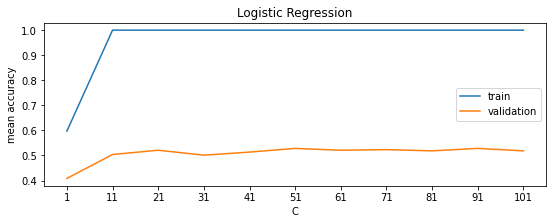

In [227]:
fig=plt.figure(figsize=(9,3))
ax = fig.add_subplot(111)
plt.plot(C, mean_train, label="train")
plt.plot(C, mean_val, label="validation")
plt.title("Logistic Regression")
plt.ylabel("mean accuracy")
plt.xlabel("C")
plt.xticks(C)
plt.legend();

In [228]:
LR_model = LogisticRegression(C=91, max_iter=1000, penalty='l1', solver='liblinear', random_state=42)
LR_model.fit(X_train, Y_train)

LogisticRegression(C=91, max_iter=1000, penalty='l1', random_state=42,
                   solver='liblinear')

## Support Vector Classifier (SVC)

In [229]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
# define the hyperparameter grid to search over
C=np.arange(0.5, 2, 0.1)
param_grid = {'C': C,'kernel': ['sigmoid'],'gamma': ['scale']}
# create an SVM classifier
svm_clf = SVC(random_state=42)
svm_clf.fit(X_train,Y_train)
# perform a grid search over the hyperparameter grid using cross-validation
grid_search = GridSearchCV(estimator=svm_clf, param_grid=param_grid, cv=5,\
                           return_train_score=True)
grid_search.fit(X_train, Y_train)
# Get the best hyperparameters
best_params = grid_search.best_params_
print(best_params)
best_score = grid_search.best_score_
mean_train = grid_search.cv_results_['mean_train_score']
mean_val   = grid_search.cv_results_['mean_test_score']
print("mean weighted train score={}".format(mean_train))
print("mean weighted validation score={}".format(mean_val))
print("best validation score={}".format(best_score))

#val acc ~ 37%

{'C': 1.5999999999999996, 'gamma': 'scale', 'kernel': 'sigmoid'}
mean weighted train score=[0.37898299 0.38570709 0.39426046 0.40403334 0.42237451 0.43521481
 0.45171739 0.4645521  0.46883345 0.48227419 0.48961177 0.49327777
 0.50122324 0.50611061 0.518936  ]
mean weighted validation score=[0.33020175 0.3253237  0.33020175 0.3350798  0.34242698 0.34730503
 0.35218308 0.35953026 0.35465221 0.3546221  0.3643782  0.37172538
 0.36928636 0.36684734 0.36928636]
best validation score=0.37172538392050586


In [230]:
SVC_model = SVC(C=best_params['C'], kernel=best_params['kernel'], random_state=42)
SVC_model.fit(X_train,Y_train)

SVC(C=1.5999999999999996, kernel='sigmoid', random_state=42)

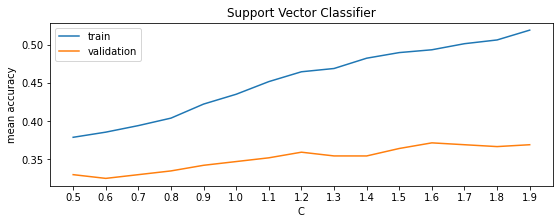

In [231]:
fig=plt.figure(figsize=(9,3))
ax = fig.add_subplot(111)
plt.plot(C, mean_train, label="train")
plt.plot(C, mean_val, label="validation")
plt.title("Support Vector Classifier")
plt.ylabel("mean accuracy")
plt.xlabel("C")
plt.xticks(C)
plt.legend();

### RandomForest Classifier

In [232]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

rf_clf = RandomForestClassifier(random_state=42)

# define a range of  values to search over
#
# param_grid = {'n_estimators': [50, 100, 200, 400, 800]}  # 400 best

max_depth_vec=np.arange(1,16,1)
param_grid = {'max_depth': max_depth_vec}

# perform a grid search over the n_estimators values
grid_search = GridSearchCV(rf_clf, param_grid, cv=5, return_train_score=True)
grid_search.fit(X_train, Y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_
best_score=grid_search.best_score_

mean_train = grid_search.cv_results_['mean_train_score']
mean_val   = grid_search.cv_results_['mean_test_score']
print("mean weighted train scores={}".format(mean_train))
print("mean weighted validation scores={}".format(mean_val))

# print the best n_estimators value and corresponding score
print("Best max_depth: {}".format(best_params['max_depth']))
print("Best validation score: {:.2f}%".format(best_score*100))

#val acc ~ 39%

mean weighted train scores=[0.19192399 0.23897777 0.30804803 0.35391214 0.38446334 0.41319833
 0.43520176 0.44803461 0.46821437 0.49144477 0.50978407 0.53423025
 0.55683598 0.58495935 0.61858544]
mean weighted validation scores=[0.18581752 0.20788919 0.24218609 0.2836495  0.29590485 0.32035531
 0.31797651 0.32529359 0.34230653 0.35943993 0.35940982 0.36190906
 0.37166516 0.39620596 0.38383017]
Best max_depth: 14
Best validation score: 39.62%


In [233]:
RFC_model = RandomForestClassifier(n_estimators=400, max_depth=14, random_state=42)
RFC_model.fit(X_train, Y_train)

RandomForestClassifier(max_depth=14, n_estimators=400, random_state=42)

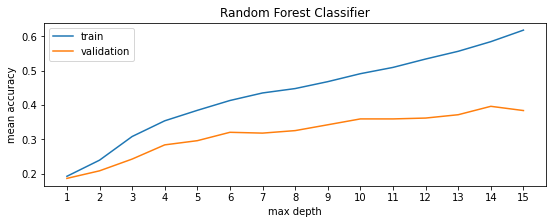

In [234]:
fig=plt.figure(figsize=(9,3))
ax = fig.add_subplot(111)
plt.plot(max_depth_vec, mean_train, label="train")
plt.plot(max_depth_vec, mean_val, label="validation")
plt.title("Random Forest Classifier")
plt.ylabel("mean accuracy")
plt.xlabel("max depth")
plt.xticks(max_depth_vec)
plt.legend();

## K Nearest Neighbor (KNN)

In [235]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

# Create an instance of KNN
knn = KNeighborsClassifier()

K=np.arange(1,10,1)

# Define the hyperparameters to tune
param_grid = {'n_neighbors': K, 'weights': ['uniform']}

# Use Grid Search to find the best hyperparameters using croo validation
grid_search = GridSearchCV(knn, param_grid, cv=5, return_train_score=True)
grid_search.fit(X_train, Y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_
print(best_params)
best_score=best_params = grid_search.best_params_

mean_train = grid_search.cv_results_['mean_train_score']
mean_val   = grid_search.cv_results_['mean_test_score']
print("mean weighted train score={}".format(mean_train))
print("mean weighted validation score={}".format(mean_val))
print("best validation score score={}".format(best_score))
# val acc ~ 34%

{'n_neighbors': 8, 'weights': 'uniform'}
mean weighted train score=[1.         0.62531327 0.55991833 0.52568807 0.49573544 0.47923473
 0.45600433 0.44744163 0.44377564]
mean weighted validation score=[0.22505269 0.27154472 0.27886179 0.29834387 0.31056911 0.31550738
 0.33760915 0.344866   0.32529359]
best validation score score={'n_neighbors': 8, 'weights': 'uniform'}


In [236]:
# Train a new KNN model with the best hyperparameters
KNN_model = KNeighborsClassifier(n_neighbors=best_params['n_neighbors'],weights=best_params['weights']);
KNN_model.fit(X_train, Y_train)

KNeighborsClassifier(n_neighbors=8)

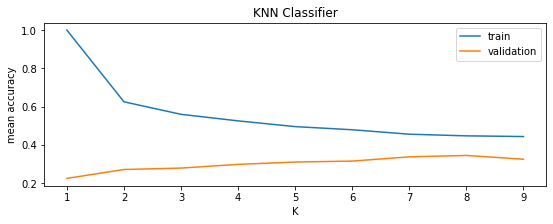

In [237]:
fig=plt.figure(figsize=(9,3))
ax = fig.add_subplot(111)
plt.plot(K, mean_train, label="train")
plt.plot(K, mean_val, label="validation")
plt.title("KNN Classifier")
plt.ylabel("mean accuracy")
plt.xlabel("K")
plt.xticks(K)
plt.legend();

## predict: run the selected model on the Kaggle test set data
After selecting the best model based on accuracy on validation data, run the model on the unseen test data, save predictions to a csv file, and submit the csv file to Kaggle. And hopefully move up the leaderboard.

In [238]:
test_dataset = test_dataset.drop(["top genre"], axis=1)

In [239]:
#feature scaling on test dataset

test_dataset_arr=test_dataset.values
test_dataset_arr[:,:9]=scaler.fit_transform(test_dataset_arr[:,:9]) 

In [240]:
# select a trained model to run on the test data.
#
logistic_regression=False
svc_classification=True
knn_classification=False
rf_classification=False

if logistic_regression:
    y_test_pred = LR_model.predict(test_dataset_arr)
    file_name="y_pred_lrc.csv"
if svc_classification:
    y_test_pred = SVC_model.predict(test_dataset_arr)
    file_name="y_pred_svc.csv"
if rf_classification:   
    y_test_pred = RFC_model.predict(test_dataset_arr)
    file_name="y_pred_rfc.csv"
if knn_classification:   
    y_test_pred = KNN_model.predict(test_dataset_arr)
    file_name="y_pred_knnc.csv"

In [241]:
# save Kaggle predictions to csv file 
#
def save_y_pred(X_TEST_Id, y_pred_test, file_name):
  with open(file_name, 'w') as f:
    f.write("Id," + "top genre\n")
    for ii in range(113):
      f.write(str(X_TEST_Id[ii]) + ",")
      f.write(y_pred_test[ii]+"\n")
      #print(y_pred_test[ii])

TEST_Id= test_df.iloc[:,:1].values
TEST_Id=TEST_Id.flatten()
TEST_Id=list(TEST_Id)
y_test_pred=list(y_test_pred)
save_y_pred(TEST_Id, y_test_pred, file_name)